In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tools
import fitutils as ft
import schottky_analysis
import near0_linear_analysis

In [2]:

# Data import

from data import temperature
from data import sample_HC
from data import err_sample_HC
from data import err_temperature

squared_temperature = temperature**2  # K**2
C_div_T = sample_HC/temperature  # mJ/K**2.mol
err_C_divT = sample_HC*((err_temperature/temperature) **
                        2 + (err_sample_HC/sample_HC)**2) # error on C/T
err_squared_temperature = (temperature)*2*err_temperature # error on T²


In [3]:
# Constants

k = 1.380649e-23 # Boltzmann, J/K
delta = 2.9461005*k*2.4 
r = 8.31446261815324  # J/mol.K

### I. Plotting data

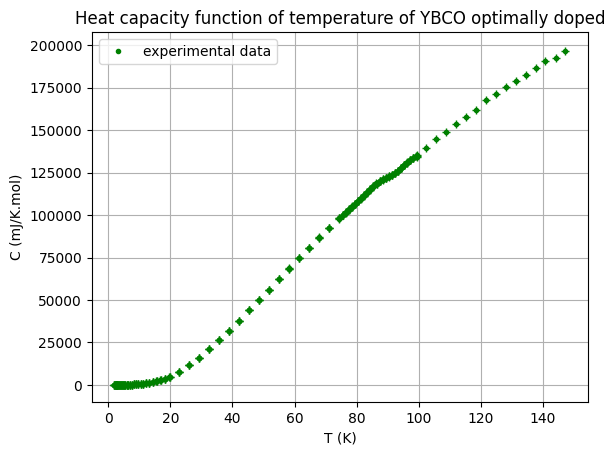

In [4]:
# Plot of HC(T)

plt.figure()
plt.plot(temperature, sample_HC, ".g", label="experimental data")
plt.errorbar(temperature, sample_HC, err_sample_HC, err_temperature, "+g")
plt.grid(True)
plt.xlabel("T (K)")
plt.ylabel("C (mJ/K.mol)")
plt.title("Heat capacity function of temperature of YBCO optimally doped")
plt.legend()
plt.show()


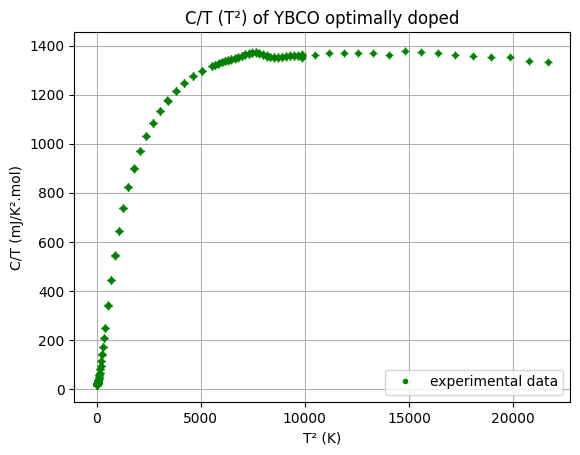

In [5]:
# Plot of HC/T (T**2)

plt.figure()
plt.plot(squared_temperature, C_div_T, ".g", label="experimental data")
plt.errorbar(squared_temperature, C_div_T, err_C_divT,
             err_squared_temperature, "+g")
plt.grid(True)
plt.xlabel("T² (K)")
plt.ylabel("C/T (mJ/K².mol)")
plt.title("C/T (T²) of YBCO optimally doped")
plt.legend()
plt.show()

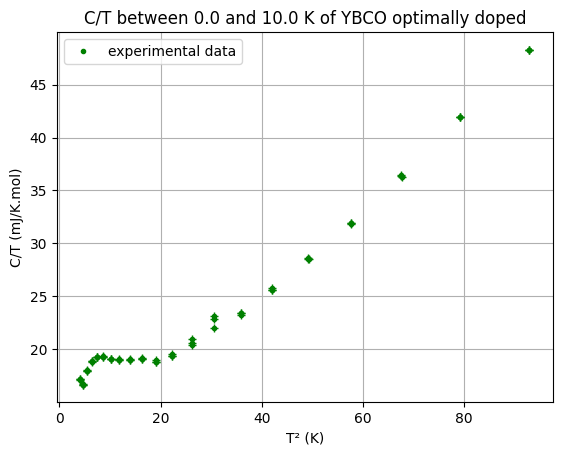

In [6]:
# Plot of HC/T (T²) near 0

# Choose of bounds

a = int(input("Input the lower bound of T² : "))
b = int(input("Input the higher bound of T² : "))
x, y = tools.tab_interval(squared_temperature, C_div_T, a, b)
x_err, y_err = err_squared_temperature[0:len(x)], err_C_divT[0:len(y)]
a_sqrt = str(np.sqrt(a))
b_sqrt = str(np.sqrt(b))
title = "C/T between " + a_sqrt + " and "  + b_sqrt + " K of YBCO optimally doped"

# Plotting 

plt.figure()
plt.plot(x, y, ".g", label="experimental data")
plt.errorbar(x, y, y_err, x_err, "+g")
plt.grid(True)
plt.xlabel("T² (K)")
plt.ylabel("C/T (mJ/K.mol)")
plt.title(title)
plt.legend()
plt.show()

### II. Schottky anomaly study

L'anomalie de Schottky est un terme intervenant dans l'expression de la chaleur spécifique de certains solides à basse température ; il est dû à l'existence d'un système à deux niveaux d'énergie, et est modélisé comme tel. Son expression est ainsi : 
$$C_{s} = n R (\frac{E}{k_B T})^2 \frac{\exp(\frac{E}{k_B T})}{(\exp(\frac{E}{k_B T}) + 1)²}$$

Les paramètres à définir sont donc $n$ (proportion d'atomes participant au système) et $E$, le gap d'énergie entre les deux niveaux. 

Pour déterminer $E$, on peut trouver une relation entre l'abscisse du maximum de la courbe $T_{max}$ et $E$, telle que $E = \alpha T_{max} {B}$. 

Pour déterminer le $\alpha$, on calcule la dérivée de Schottky : $$\frac{dC_s}{dT} = $$ Elle s'annule pour $(2T +) .. = 0$. Cette équation est uniquement solvable numériquement, ce que nous avons fait ici avec l'algorithme de Newton-Raphson. On trouve $\alpha = 2.512$. 

On détermine ensuite le maximum de la courbe et la température $T_max$pour laquelle il est atteint à partir des données expérimentales à basse température ($< 4 K$). On trouve $T_{max} = 2.9461005 K$ et $C_s(T_{max}) = 19.3365 mJ.K^{-2}.mol{-1}$.

Concernant $n$, la proportion de sites impliqués dans le sysème, on peut déterminer son ordre de grandeur pour chaque point expérimental, une fois la valeur de $E$ estimée. Bien que bruitée par les contributions des autres termes, la moyenne des valeurs de n calculées entre $1 K$ et $4 K$, ou l'anomalie de Schottky domine, peut donner une bonne approximation :

In [7]:
# Find the relation between the extremum of Schottky anomaly and T_max

alpha = schottky_analysis.alpha()

T_max, maximum = schottky_analysis.max_schottky(temperature, C_div_T, 0, 4.5)

# Determination of E parameter

E_experimental = k*alpha*T_max

# Determination of n parameter

n_experimental = schottky_analysis.n_experimental(temperature[0:25], C_div_T[0:25], E_experimental) #approximation de n entre 0 et 4 K

print(alpha, T_max, maximum, E_experimental, n_experimental)


2.399357557296753 2.9461005 19.33658610763618 9.759460546714425e-23 0.002086138736124589


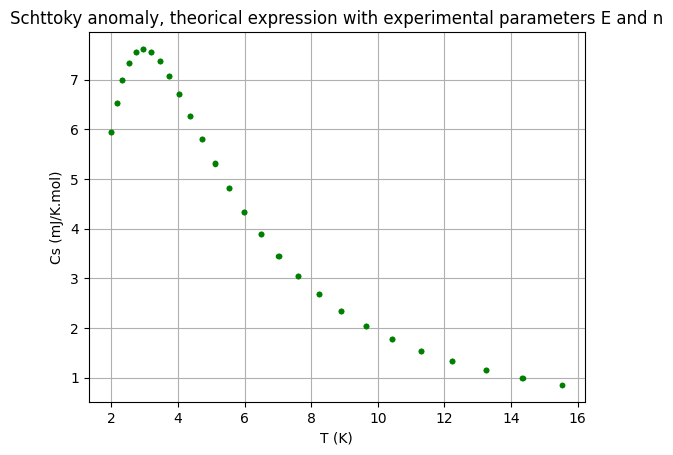

In [8]:
# Plotting Schottky

plt.figure()
plt.plot(temperature[0:80], schottky_analysis.schottky(temperature[0:80], E_experimental, n_experimental), ".g")
plt.grid(True)
plt.xlabel("T (K)")
plt.ylabel("Cs (mJ/K.mol)")
plt.title("Schttoky anomaly, theorical expression with experimental parameters E and n")
plt.show()


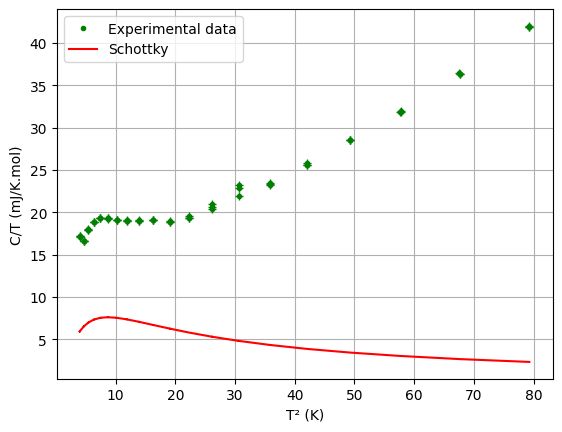

In [9]:
# Plot of HC/T and Cs (T²) near 0

# Choose of bounds

a = int(input("Input the lower bound of T² : "))
b = int(input("Input the higher bound of T² : "))
x, y = tools.tab_interval(squared_temperature, C_div_T, a, b)
x_err, y_err = err_squared_temperature[0:len(x)], err_C_divT[0:len(y)]

# Plotting 

plt.figure()
plt.plot(x, y, ".g", label="Experimental data")
plt.plot(x, schottky_analysis.schottky(temperature[0:len(x)], E_experimental, n=n_experimental), "r-", label="Schottky")
plt.errorbar(x, y, y_err, x_err, "+g")
plt.grid(True)
plt.xlabel("T² (K)")
plt.ylabel("C/T (mJ/K.mol)")
plt.legend()
plt.show()

In [10]:
30*3/(0.44*8.32)

24.58479020979021

### III. Linear regression 

La loi théorique que suit $\frac{C}{T}$ est telle que : $\gamma + \beta T² + C_{schottky} $. En sosutrayant la contribution de Scottky, et en considérant les données en fonction de $T²$, on obtient donc une loi linéaire : $\gamma + \beta x$, ($x = T²$). Un ajustment linéaire pemet ensuite de retrouver les paramètre $\gamma$ et $\beta$.

Le paramètre $\beta$ est lié à la température de Debye du composé par la loi : $T_D = (\frac{12 R \pi ^4}{5 \beta})^{\frac{1}{3}}$. 

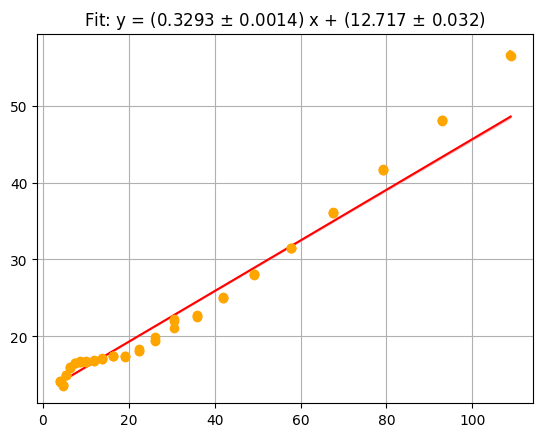

array([3.29308313e-01, 1.27167113e+01, 1.37345191e-03, 3.15842790e-02])

In [ ]:
# Linear fit of experimental data

near0_linear_analysis.plot_linear_fit(65, E=E_experimental, n=n_experimental)

# Debye temperature



### IV. Non-linear regression